In [1]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [2]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/hse06_dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

/Users/badw/github-projects/arcs/arcs/generate.py:255: RuntimeWarning: overflow encountered in exp
  K = np.exp(


#### 2. Sample the `graph`

In [3]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### 3. generate reaction statistics

In [18]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(10)

1 H2S + 2 NO2 = 1 H2SO4 + 1 N2    397
1 H2O + 1 SO2 = 1 H2SO3           274
2 H2O = 1 O2 + 2 H2               259
1 H2O + 1 NO = 1 NO2 + 1 H2       159
1 H2S + 1 O2 = 1 H2 + 1 SO2       143
2 H2O + 2 SO2 = 2 H2S + 3 O2      141
2 H2O + 1 H2S = 3 H2 + 1 SO2      104
3 H2O + 1 H2S = 3 H2 + 1 H2SO3    100
2 H2O + 1 SO2 = 1 H2 + 1 H2SO4     93
1 H2O + 1 NO2 + 1 NO = 2 HNO2      71
dtype: int64

#### 4. generate mean concentrations and differences

In [19]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(5)
average_data.sort_values(by='diff',inplace=True)
average_data.round(2)

,initial,mean,diff,std,var
NO2,10.0,4.95,-5.05,4.94,24.36
SO2,10.0,6.49,-3.51,5.33,28.40
H2O,30.0,26.50,-3.50,6.25,39.09
H2S,10.0,6.94,-3.06,3.44,11.83
O2,10.0,8.89,-1.11,5.32,28.27
NH3,0.0,0.04,0.04,0.49,0.24
S8,0.0,0.09,0.09,0.29,0.08
HNO2,0.0,0.23,0.23,1.06,1.12
NO,0.0,0.32,0.32,1.69,2.87
NOHSO4,0.0,0.34,0.34,1.39,1.94


#### 5. Plot 

<Axes: >

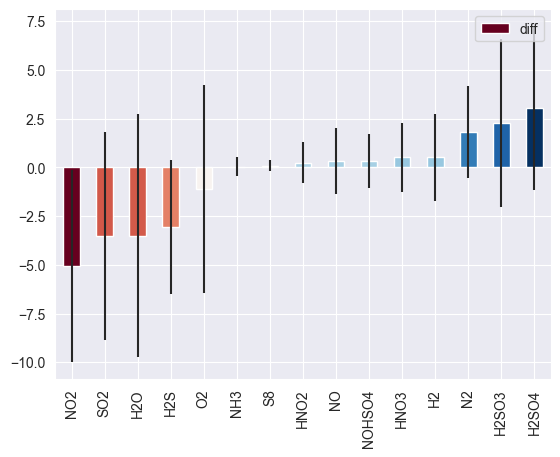

In [20]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [ ]:
g = analysis.result_to_pyvis(data,head=5,filename='example_pyvis_graph.html')